### Libraries

In [1]:
import sys
sys.path.insert(0, '/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import *
%matplotlib inline

import re

### Script Settings

In [2]:
date_start = '2018-01-01'
date_end = '2019-01-31'

write_pdf = 'yes'
report_dict = {}

ym = pd.DataFrame({'year and month':pd.date_range(date_start, date_end, freq = 'MS')})
ym['year and month'] = [str(x)[:7] for x in ym['year and month']]
ym.set_index('year and month', inplace = True)

pretty_dates = list(ym.index)
pretty_dates = [calendar.month_abbr[int(x[-2:])] + '\n' + x[:4] for x in pretty_dates]

csv_path = '/Users/jarad/Fake Folder/Finance/Recurring/Amazon Monthly Audit/CSVs/Statements/'

html_path = '/Users/jarad/Fake Folder/Finance/Recurring/Amazon Monthly Audit/HTML/'
html_title = 'Amazon Monthly Audit.html'

style_sheet_path = '/Users/jarad/Fake Folder/CSS Stylesheets/Recurring Reports Stylesheet.css'

pdf_path = '/Users/jarad/Fake Folder/Finance/Recurring/Amazon Monthly Audit/Docs/Monthly Reports/'

image_path = '/Users/jarad/Fake Folder/Finance/Recurring/Amazon Monthly Audit/Images/'

now_pretty = str(dt.datetime.now().date())

### Chart settings

In [3]:
#plt.rcdefaults()
#plt.rcParams.keys()

plt.rcParams['lines.linewidth'] = 5
plt.rcParams['legend.fontsize'] = 20

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif'] = 'Arial'

plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titleweight'] = 'bold'

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.labelweight'] = 'bold'

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

colors = ['#ccc6dd',
          '#918aa7',
          '#5c576f',
          '#352f45']

### Note this table that we no longer use

In [4]:
pd.read_sql(
'''
SELECT
MAX(DATE(transaction_posted_date_1)) AS 'max date'
FROM lapwa_billing
ORDER BY transaction_posted_date_1 DESC
''', db)

,max date
0,2017-08-03


### Get database data

In [5]:
lapwa_log_main = pd.read_sql(
'''
SELECT
timestamp,
order_id AS orders_id,
LOWER(action) AS action,
order_reference_id,
amount AS lapwa_log_amount
FROM lapwa_log
''', db)

orders_main = pd.read_sql(
'''
SELECT
DATE(o.date_purchased) AS date_purchased,
DATE_FORMAT(o.date_purchased, '%Y-%m') AS year_and_month_purchased,
o.orders_id,
ot.value AS ot_amount,
os.orders_status_name AS orders_status,
IF(o.orders_id IN (SELECT orders_id FROM orders_deleted),'yes','no') AS deleted
FROM orders o 
JOIN orders_total ot ON o.orders_id = ot.orders_id
AND ot.class = 'ot_total'
JOIN orders_status os ON o.orders_status = os.orders_status_id
WHERE o.payment_module_code = 'lapwa'
''', db)

for df in [lapwa_log_main, orders_main]:
    col_fix(df)
    
lapwa_log_main.sort_values(['order reference id','timestamp'], inplace = True)
lapwa_log_main.drop_duplicates(['orders id','action'], keep = 'last', inplace = True)    

In [6]:
pd.read_sql(
'''
SELECT
*
FROM orders_status
ORDER BY orders_status_id
''', db)

,orders_status_id,language_id,orders_status_name
0,1,1,Pending
1,2,1,Processing
2,3,1,Shipped
3,4,1,Update
4,5,1,Printed
5,6,1,Billed
6,7,1,Payment Received
7,8,1,Fraud - Pending
8,9,1,Fraud - Confirmed
9,10,1,Return


In [7]:
ot = pd.read_sql(
'''
SELECT
DATE_FORMAT(o.date_purchased, '%Y-%m') As year_and_month,
SUM(ot.value) AS monthly_total
FROM orders_total ot
JOIN orders o ON ot.orders_id = o.orders_id
AND DATE(o.date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND orders_status NOT IN (8,9,10,11,12,14,15)
AND payment_method != 'Replacement Order'
WHERE ot.class = 'ot_subtotal'
GROUP BY DATE_FORMAT(o.date_purchased, '%Y-%m')
''', db)
col_fix(ot)

### Reconcile tables in database

In [8]:
# assemble main df
db_rec_main = pd.merge(lapwa_log_main, orders_main, how = 'left', on = 'orders id')

# get it by OID
by_oid = db_rec_main.groupby(['orders id','action'])[['ot amount']].sum().unstack(1).fillna(0)
by_oid.columns = by_oid.columns.droplevel(0)
by_oid.reset_index(inplace = True)

# join some info
df = orders_main[['orders status','date purchased','year and month purchased','orders id']]

by_oid = pd.merge(by_oid, df, how = 'left', on = 'orders id')

# get mismatches
mismatch = by_oid[np.abs(by_oid['authorize'] - by_oid['capture']) > 1].copy()
mismatch['difference'] = mismatch['authorize'] - mismatch['capture']

# get current mismatches
mismatch_current = mismatch[mismatch['date purchased'].between(pd.to_datetime(date_start).date(), pd.to_datetime(date_end).date())].groupby(['year and month purchased','orders status'])[['difference']].sum().unstack(1).fillna(0)
mismatch_current.columns = mismatch_current.columns.droplevel(0)
mismatch_current = ym.join(mismatch_current).fillna(0)

mismatch_current.format_(['m0'] * len(mismatch_current.columns))

s1 = set(['Fraud - Void', 'Voided']) # mismatches are ok here in these columns
s2 = set(mismatch_current.columns.tolist())

if len(s1.symmetric_difference(s2)) == 0:
    pass
else:
    raise ValueError('check this out')

### Get CSV data

In [9]:
# get all CSVs
all_files = glob.glob(csv_path + '/*.csv')
frame = pd.DataFrame()
list_ = []

for file_ in all_files:
    df = pd.read_csv(file_, index_col = None, header = 0)
    list_.append(df)
    
csv_main = pd.concat(list_)    

# clean column headers
columns_list = []
for y in csv_main.columns:
    columns = '_'.join(x.lower() for x in re.findall('[A-Z][^A-Z]*', y))
    columns_list.append(columns)
    
csv_main.columns = columns_list 

# fix column headers
csv_main.columns = [x.replace('_',' ') for x in csv_main.columns]
csv_main.columns = [x.lstrip().rstrip() for x in csv_main.columns]

# convert to datetime and get rid of time units
csv_main['transaction posted date'] = pd.to_datetime(csv_main['transaction posted date'])
csv_main['posted date'] = pd.to_datetime(csv_main['transaction posted date']).dt.date
csv_main['posted date'] = pd.to_datetime(csv_main['posted date'])
csv_main['year and month posted'] = [str(x)[:7] for x in csv_main['posted date']]

# convert to numeric
ls = ['transaction amount',
      'transaction percentage fee',
      'transaction fixed fee',
      'total transaction fee',
      'net transaction amount']

for col in ls:
    try:
        csv_main[col] = csv_main[col].str.replace(',','')
    except:
        pass
    csv_main[col] = pd.to_numeric(csv_main[col])
    
# rename
csv_main.rename(columns = {'amazon order reference id':'order reference id',
                          'transaction type':'action',
                          'transaction amount':'csv amount',
                          'total transaction fee':'csv transaction fee',
                          'net transaction amount':'csv net amount'}, inplace = True)    

# keep only the columns you want
csv = csv_main.copy()
csv = csv[[
     'transaction posted date', 
     'posted date',
     'year and month posted',
     'amazon transaction id',
     'action',
     'order reference id',
     'csv amount',
     'csv transaction fee',
     'csv net amount']]

# change the wording of this label
csv['action'] = np.where(csv['action'] == 'authorization', 'authorize', csv['action'])

# lower case
csv['action'] = [x.lower() for x in csv['action']]

# dupes, we download statements from amazon.com which overlap in time, which is why we have dupes
csv.drop_duplicates(inplace = True)

s1 = set(['reserve', 'transfer', 'debt'])
s2 = set(csv['action'][(csv['order reference id'].isnull())])

if len(s1.symmetric_difference(s2)) == 0:
    pass
else:
    raise ValueError('check this out')

### Reconcile CSV with database

In [10]:
# we know now that the db tables are reconciled
# so join this db table to the CSV statement
csv_recon_main = pd.merge(csv, lapwa_log_main, how = 'left', on = ['order reference id','action'])

# get some dates
for col in ['date purchased','year and month purchased']:
    csv_recon_main[col] = csv_recon_main['orders id'].map(dict(zip(orders_main['orders id'], orders_main[col])))

# get last 13 months by date_purchased    
csv_recon_main = csv_recon_main[csv_recon_main['posted date'].between(date_start, date_end)].copy()    

# get values of all actions between CSV and db
df = csv_recon_main.groupby(['year and month posted','action'])[['csv amount','lapwa log amount']].sum()

# refunds are negative in the CSV, positive in the db, take the abs value
df['csv amount'] = np.abs(df['csv amount'])

# take the differemce
df['difference'] = df['csv amount'] - df['lapwa log amount']

# now we have the differences between the CSV and the lapwa log db table
# we only care about mismatches here in these columns
ls = ['authorization','capture']

if (df[(df.index.get_level_values(0) == date_end[:7]) & (df.index.get_level_values(1).isin(ls))]['difference'] == 0).all():
    pass
else:
    raise ValueError('you have mismatches')

### Transfers

In [11]:
ls = ['transfer','capture']
trans = df[df.index.get_level_values(1).isin(ls)][['csv amount']].unstack(1)
trans.columns = trans.columns.droplevel(0)
trans['transfer as % of capture'] = trans['transfer']/trans['capture']

fmt = ['m0','m0','p1']
display(jb_mean(trans, fmt))
trans.format_(fmt)

,mean
Capture,"$176,219"
Transfer,"$170,412"
Transfer As % Of Capture,96.6%


,Capture,Transfer,Transfer As % Of Capture
year and month posted,,,
2018-01,"$189,254","$171,729",90.7%
2018-02,"$187,192","$184,767",98.7%
2018-03,"$242,529","$237,406",97.9%
2018-04,"$186,547","$186,540",100.0%
2018-05,"$157,653","$145,918",92.6%
2018-06,"$162,828","$162,928",100.1%
2018-07,"$155,056","$140,277",90.5%
2018-08,"$170,159","$175,238",103.0%
2018-09,"$147,369","$139,498",94.7%


### 95% confidence intervals for avg transfer as % of capture per month

In [12]:
vals = trans['transfer as % of capture'].values
m = np.mean(vals)
s = np.std(vals)
n = len(vals)
phi = stats.t.ppf(0.95, n-1)
l = m - phi * (s/np.sqrt(n))
u = m + phi * (s/np.sqrt(n))

trans_conf = pd.DataFrame(columns = ['lower','mean','upper'], data = [[l,m,u]])
trans_conf.format_(['p1'] * 3)

,Lower,Mean,Upper
0,94.7%,96.6%,98.5%


### Explore for report

In [13]:
# make a copy 
explore = csv.copy()

# get OID
explore['orders id'] = explore['order reference id'].map(dict(zip(lapwa_log_main['order reference id'], lapwa_log_main['orders id'])))

# get some dates
for col in ['date purchased','year and month purchased']:
    explore[col] = explore['orders id'].map(dict(zip(orders_main['orders id'], orders_main[col])))
    
# restrict by date
explore = explore[explore['posted date'].between(date_start, date_end)]

# create one big dataframe
df1 = explore.groupby(['year and month posted','action'])[['csv amount']].sum().unstack(1).fillna(0)
df1.columns = df1.columns.droplevel(0)

df2 = explore.groupby('year and month posted').agg({'csv transaction fee':'sum', 'orders id':'nunique'})
df2.columns = ['fee amount','oid count']
df2['fee amount'] = np.abs(df2['fee amount'])

df3 = df1.join(df2)
df3['fees as % of capture'] = df3['fee amount']/df3['capture']
df3['avg capture per oid'] = df3['capture']/df3['oid count']

df4 = explore[explore['action'] == 'refund'].groupby('year and month posted')[['order reference id']].count()
df4.columns = ['refund count']

df5 = df3.join(df4)
df5['refund'] = np.abs(df5['refund'])
df5['avg refunded'] = df5['refund']/df5['refund count']

df6 = df5.copy()

df7 = df6.join(ot.set_index('year and month'))
df7['capture as % of monthly total'] = df7['capture']/df7['monthly total']

df7 = df7.loc[:,(df7 != 0).all(0)].copy()

fmt = ['m2','m2','m2','m2','n0','p1','m2','n0','m2','m2','p1']

mean = jb_mean(df7, fmt)

yoy = pd.DataFrame((df7.pct_change(periods = 12).iloc[-1]))#.format_(['p1']).replace('nan%','')
yoy.columns = ['yoy']
yoy = yoy.T
yoy = yoy.format_(['p1'] * len(fmt)).replace('nan%','')
yoy = yoy.T

display(mean.join(yoy))
df7.format_(fmt)

,mean,yoy
Capture,"$176,218.93",-8.6%
Refund,$823.28,-72.2%
Transfer,"$-170,411.94",-2.6%
Fee Amount,"$5,132.11",-10.1%
OID Count,"2,476",-14.2%
Fees As % Of Capture,2.9%,-1.6%
Avg Capture Per OID,$71.28,6.5%
Refund Count,17,-39.3%
Avg Refunded,$49.24,-54.2%
Monthly Total,"$3,575,547.24",-2.0%


,Capture,Refund,Transfer,Fee Amount,OID Count,Fees As % Of Capture,Avg Capture Per OID,Refund Count,Avg Refunded,Monthly Total,Capture As % Of Monthly Total
year and month posted,,,,,,,,,,,
2018-01,"$189,254.32","$1,699.51","$-171,729.16","$5,573.03","2,883",2.9%,$65.64,28,$60.70,"$3,539,519.81",5.3%
2018-02,"$187,191.59",$935.97,"$-184,766.62","$5,481.32","2,630",2.9%,$71.18,15,$62.40,"$3,312,539.03",5.7%
2018-03,"$242,528.86",$931.00,"$-237,405.79","$7,055.25","3,381",2.9%,$71.73,18,$51.72,"$4,369,445.90",5.6%
2018-04,"$186,546.75",$601.58,"$-186,540.32","$5,404.04","2,583",2.9%,$72.22,17,$35.39,"$3,705,274.81",5.0%
2018-05,"$157,653.17",$521.71,"$-145,917.87","$4,583.31","2,143",2.9%,$73.57,11,$47.43,"$3,933,957.74",4.0%
2018-06,"$162,828.27",$872.49,"$-162,928.26","$4,711.83","2,209",2.9%,$73.71,14,$62.32,"$3,272,854.06",5.0%
2018-07,"$155,056.02",$870.16,"$-140,276.69","$4,514.37","2,182",2.9%,$71.06,15,$58.01,"$3,448,739.19",4.5%
2018-08,"$170,159.20",$916.89,"$-175,237.55","$4,922.94","2,229",2.9%,$76.34,17,$53.93,"$3,141,296.40",5.4%
2018-09,"$147,368.74",$644.97,"$-139,497.88","$4,323.33","2,115",2.9%,$69.68,10,$64.50,"$3,081,420.20",4.8%


### For report: revenue and AOV

In [14]:
a = df7.iloc[-1]['capture']
b = df7.iloc[0]['capture']
c = a/b-1

w1 = 'Amazon revenue {} {:,.1f}% year over year, {} from ${:,.0f} to ${:,.0f}.'.format('decreased' if c < 0 else 'increased',
                                                                                      np.abs(c) * 100,
                                                                                      'down' if c < 0 else 'up',
                                                                                      b,
                                                                                      a)
report_dict['revenue write'] = w1

a = df7.iloc[-1]['capture as % of monthly total']
b = df7['capture as % of monthly total'].mean()

if np.abs(a-b) < 0.02:
    res = 'about equal to'
else:
    if a < b:
        res = 'below'
    else:
        res = 'above'

w2 = 'As a proportion of total monthly revenue, Amazon constituted {:,.1f}%, {} the average of {:,.1f}%.'.format(a * 100,
                                                                                                               res,
                                                                                                               b * 100)
report_dict['proportion write'] = w2

a = df7.iloc[-1]['avg capture per oid']
b = df7.iloc[0]['avg capture per oid']
c = a/b-1
w3 = 'The average order value (AOV) {} {:,.1f}% year over year, {} from ${:,.2f} to ${:,.2f}.'.format('fell' if c < 0 else 'rose',
                                                                                                     np.abs(c) * 100,
                                                                                                     'down' if c < 0 else 'up',
                                                                                                     b,
                                                                                                     a)

report_dict['aov write'] = w3
print('\n'.join([w1,w2,w3]))

Amazon revenue decreased 8.6% year over year, down from $189,254 to $172,987.
As a proportion of total monthly revenue, Amazon constituted 5.0%, about equal to the average of 4.9%.
The average order value (AOV) rose 6.5% year over year, up from $65.64 to $69.89.


### For report: fees

In [15]:
a = df7.iloc[-1]['fee amount']
b = df7.iloc[-1]['fees as % of capture']
c = df7['fees as % of capture'].mean()

if np.abs(b-c) < 0.02:
    res = 'in-line with'
else:
    if b < c:
        res = 'below'
    else:
        res = 'above'

w1 = 'The total fee amount hit ${:,.0f}, or {:,.1f}% of Amazon revenue, which is {} the monthly average of {:,.1f}%.'.format(a,
                                                                                                                             b * 100,
                                                                                                                             res,
                                                                                                                             c * 100)
report_dict['fees write'] = w1
report_dict['fees write']

'The total fee amount hit $5,011, or 2.9% of Amazon revenue, which is in-line with the monthly average of 2.9%.'

### For report: total refund amount

In [16]:
a = df7.iloc[-1]['refund']
b = df7.iloc[0]['refund']
c = a/b-1

w1 = 'The total amount refunded {} {:,.1f}% year over year, {} from ${:,.0f} to ${:,.0f}.'.format('decreased' if c < 0 else 'increased',
                                                                                                 np.abs(c) * 100,
                                                                                                 'down' if c < 0 else 'up',
                                                                                                 b,
                                                                                                 a)
d = (df7['refund']).mean()
w2 = 'This total refund amount is {} the monthly average of ${:,.0f}.'.format('below' if a < d else 'above',
                                                                              d)

write = ' '.join([w1,w2])
report_dict['total refund write'] = write
report_dict['total refund write']

'The total amount refunded decreased 72.2% year over year, down from $1,700 to $472. This total refund amount is below the monthly average of $823.'

### For report: avg refund amount

In [17]:
a = df7.iloc[-1]['avg refunded']
b = df7.iloc[0]['avg refunded']
c = a/b-1

w1 = 'The average amount refunded {} {:,.1f}% year over, {} from ${:,.2f} to ${:,.2f}.'.format('fell' if c < 0 else 'rose',
                                                                                              np.abs(c) * 100,
                                                                                              'down' if c < 0 else 'up',
                                                                                              b,
                                                                                              a)
report_dict['avg refund write'] = w1
report_dict['avg refund write']

'The average amount refunded fell 54.2% year over, down from $60.70 to $27.78.'

### Refunds for current month

In [18]:
d = date_end[:7]
r = explore[(explore['year and month posted'] == d)
          & (explore['action'] == 'refund')].sort_values('csv amount')
r['orders id'] = [int(x) for x in r['orders id']]
r['csv amount'] = np.abs(r['csv amount'])

t = r['csv amount'].sum()
if np.abs(df7.iloc[-1]['refund'] - t) > 1:
    raise ValueError('Refund totals do not match')
else:    
    print('total refund amount is ${:,.0f}'.format(t))

if t != r['csv amount'].sum():
    raise ValueError('you refund total don\'t match')

r2 = r.groupby('orders id', as_index = False)[['csv amount']].sum().sort_values('csv amount', ascending = False)
r2.format_([0,'m2'])

total refund amount is $472


,Orders Id,Csv Amount
2,1931224,$85.33
12,1949828,$75.17
7,1942321,$64.95
6,1941240,$64.75
5,1938505,$39.23
3,1933222,$26.95
9,1943120,$26.10
10,1944009,$21.10
8,1942489,$19.38
15,1954435,$13.00


### For report: current refunds

In [19]:
oids = r2.iloc[:3]['orders id'].tolist()
totals = r2.iloc[:3]['csv amount'].tolist()

link = 'https://volcano.adafruit.com/volcano/Order_Status.php?oid='

for i in range(3):
    report_dict['refund oid ' + str(i)] = str(oids[i])
    report_dict['refund link ' + str(i)] = link + str(oids[i])
    report_dict['refund amount ' + str(i)] = '${:,.0f}'.format(totals[i])

### CS Error Report

In [20]:
ref_oids = r['orders id'].iloc[:3].tolist()

In [21]:
cer = pd.read_sql(
'''
SELECT
*
FROM cs_error_reports
WHERE orders_id IN '''+ str(tuple(ref_oids)) +'''
''', db)

col_fix(cer)

if cer.empty:
    print('nothing logged')
else:
    display(cer)

,error id,timestamp,admin id,customer type,issue type,orders id,part id,sku id,error qty,forums link,customer complaint,notes,action,request return,resolved,date notified,date abandoned,reseller name,amount refunded,store credit,shipping error,amount canceled,qty ordered,qty available,flag id
0,3869,2019-01-16,33,customer,lost,1949828,0,0,1,,"A week ago, I purchased a dev kit and it never arrived. Unfortunately, it\nmay have been lost so...",,replacement,0,0,2019-01-14,2019-01-14,,0.0,0.0,,0.0,0,0,0
1,3889,2019-01-17,61,customer,lost,1949828,0,0,1,,"On the 14th, I received notice that my lost order was being investigated by\nUPS. I don't have m...",,replacement,0,0,2019-01-14,2019-01-17,,0.0,0.0,,0.0,0,0,0


### Charts for report

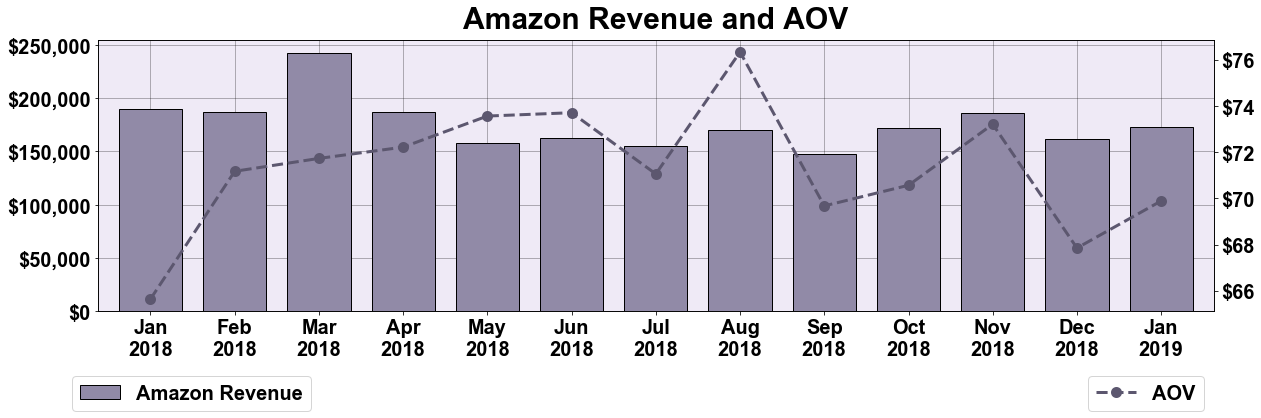

In [22]:
fig, ax = plt.subplots()

chart = np.abs(df7).copy()
chart['capture'].plot(kind = 'bar',
                        figsize = (20,5),
                        color = colors[1],
                        width = 0.75,
                        edgecolor = 'black', 
                        ax = ax,
                        zorder = 5)

ax.set_title('Amazon Revenue and AOV', y = 1.02)
ax.set_facecolor('#efeaf6')
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()])
ax.set_xlabel('')
ax.grid(color = 'black', alpha = 0.35, zorder = 0)
ax.legend(['Amazon Revenue'], bbox_to_anchor = (0.2, -0.2))

ax2 = ax.twinx()
chart['avg capture per oid'].plot(ax = ax2,
                                  ls = '--', 
                                  lw = 3, 
                                  marker = 'o',
                                  mew = 5,
                                  color = colors[2])
ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])
ax2.legend(['AOV'], bbox_to_anchor = (1, -0.2))
ax.set_xticklabels(pretty_dates, rotation = 0)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

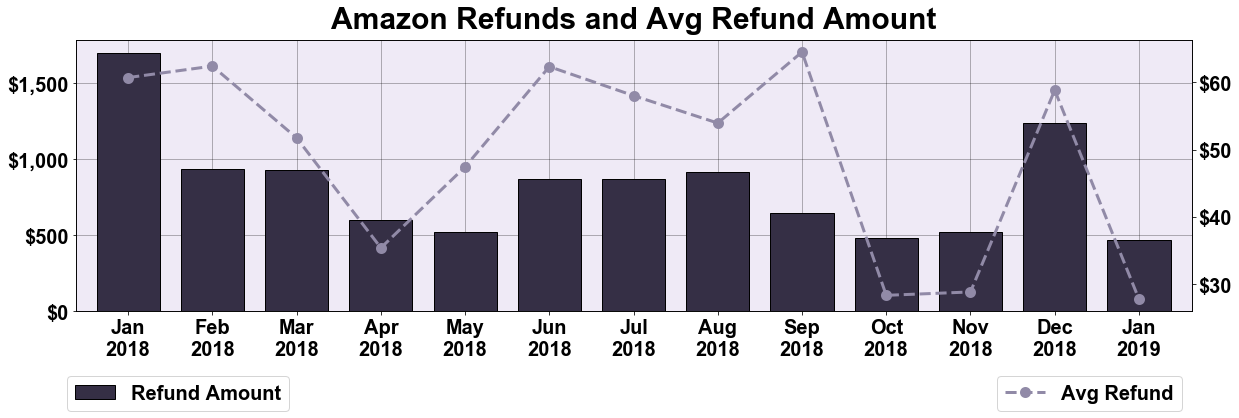

In [23]:
fig, ax = plt.subplots()

chart['refund'].plot(kind = 'bar',
                    figsize = (20,5),
                    color = colors[3],
                    width = 0.75,
                    edgecolor = 'black', 
                    ax = ax,
                    zorder = 5)

ax.set_title('Amazon Refunds and Avg Refund Amount', y = 1.02)
ax.set_facecolor('#efeaf6')
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()])
ax.set_xlabel('')
ax.grid(color = 'black', alpha = 0.35, zorder = 0)
ax.legend(['Refund Amount'], bbox_to_anchor = (0.2, -0.2))

ax2 = ax.twinx()
chart['avg refunded'].plot(ax = ax2,
                          ls = '--', 
                          lw = 3, 
                          marker = 'o',
                          mew = 5,
                          color = colors[1])
ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])
ax2.legend(['Avg Refund'], bbox_to_anchor = (1, -0.2))
ax.set_xticklabels(pretty_dates, rotation = 0)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Payment types by count

In [24]:
pay = pd.read_sql(
'''
SELECT
DATE_FORMAT(date_purchased, '%Y-%m') AS year_and_month,
payment_method
FROM orders
WHERE DATE(date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND orders_status NOT IN (9,11,12,13,14,15)
''', db)

col_fix(pay)

In [25]:
pay['payment method'] = np.where(pay['payment method'].str.contains('Purchase Order'), 'Purchase Order', pay['payment method'])

pay2 = pay.groupby(['year and month','payment method'])[['payment method']].count().unstack(1).fillna(0)
pay2.columns = pay2.columns.get_level_values(1)
pay2.sort_values(pay2.index[-1], 
                 ascending = False, 
                 axis = 1,
                 inplace = True)

pay3 = pay2.iloc[[-1]].T

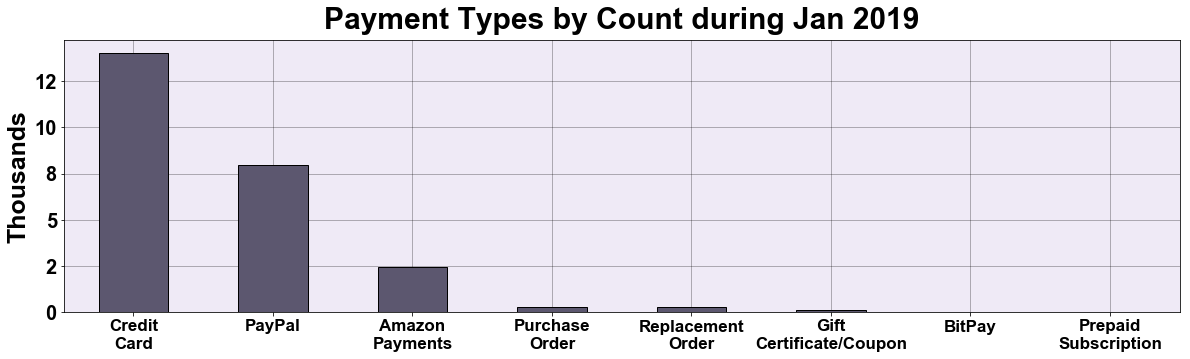

In [26]:
fig, ax = plt.subplots(figsize = (20,5))

xticks = pay3.index
xticks = [x.replace(' ','\n') for x in xticks]

d = date_end
m = calendar.month_abbr[int(d[5:7])]
y = d[:4]
d2 = m + ' ' + y

pay3.plot(kind = 'bar', ax = ax, edgecolor = 'black', color = colors[2], zorder = 5)

ax.set_yticklabels(['{:,.0f}'.format(x/1000) for x in ax.get_yticks()])
ax.set_ylabel('Thousands')
ax.set_xticklabels(xticks, rotation = 0, fontsize = 17)
ax.set_xlabel('')
ax.set_title('Payment Types by Count during %s' % d2, y = 1.02)
ax.set_facecolor('#efeaf6')
ax.legend().set_visible(False)
ax.grid(color = 'black', alpha = 0.35, zorder = 0)

plt.savefig(image_path + ax.get_title()[:22], bbox_inches = 'tight')
plt.show()

### For report: rank

In [27]:
rank = pay3.index.get_loc('Amazon Payments') + 1

if rank == 1:
    ret = 'first'
elif rank == 2:
    ret = 'second'
elif rank == 3:
    ret = 'third'
elif rank == 4:
    ret = 'fourth'
elif rank == 5:
    ret = 'fifth'    
    
report_dict['rank'] = ret
report_dict['rank']

'third'

### For report: summary

In [28]:
a = df7['capture'].pct_change(periods = 12).iloc[-1]
w1 = 'Amazon revenue {} {:,.0f}% year over year;'.format('decreased' if a < 0 else 'increased',
                                                        np.abs(a) * 100)

a = df7['avg capture per oid'].pct_change(periods = 12).iloc[-1]
w2 = 'the average order value {} {:,.0f}% year over year;'.format('fell' if a < 0 else 'rose',
                                                                  np.abs(a) * 100)
a = df7.iloc[-1]['fees as % of capture']
b = df7['fees as % of capture'].mean()

if np.abs(a-b) < 0.02:
    res = 'in-line with'
else:
    if a < b:
        res = 'less than'
    else:
        res = 'greater than'
    
w3 = 'fees were {} past months;'.format(res)

a = df7['refund'].pct_change(periods = 12).iloc[-1]
w4 = 'total amount refunded was {} {:,.0f}% year over year;'.format('down' if a < 0 else 'up',
                                                                   np.abs(a) * 100)

a = df7['avg refunded'].pct_change(periods = 12).iloc[-1]
w5 = 'average amount refunded was {} {:,.0f}% year over year;'.format('down' if a < 0 else 'up',
                                                                       np.abs(a) * 100)

a = df7.iloc[-1]['capture as % of monthly total']
w6 = 'Amazon revenue made up {:,.0f}% of total monthly revenue.'.format(a * 100)

write = ' '.join([w1,w2,w3,w4,w5,w6])
report_dict['summary write'] = write
report_dict['summary write']

'Amazon revenue decreased 9% year over year; the average order value rose 6% year over year; fees were in-line with past months; total amount refunded was down 72% year over year; average amount refunded was down 54% year over year; Amazon revenue made up 5% of total monthly revenue.'

### PDF report

In [29]:
year_and_month = calendar.month_abbr[int(date_end[5:7])] + ' ' + date_end[:4]
report_title = date_end[:4] + ' - ' + date_end[5:7] + ' - ' + calendar.month_abbr[int(date_end[5:7])] + ' - Amazon Monthly Audit'

In [32]:
if write_pdf == 'yes':
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'year_and_month':year_and_month,
                     'now':now_pretty,
                     'summary_write':report_dict['summary write'],
                     'revenue_write':report_dict['revenue write'],
                     'proportion_write':report_dict['proportion write'],
                     'aov_write':report_dict['aov write'],
                     'fees_write':report_dict['fees write'],
                     'total_refund_write':report_dict['total refund write'],
                     'avg_refund_write':report_dict['avg refund write'],
                    
                     'refund_link_0':report_dict['refund link 0'],
                     'refund_link_1':report_dict['refund link 1'],
                     'refund_link_2':report_dict['refund link 2'],
                    
                     'refund_oid_0':report_dict['refund oid 0'],
                     'refund_oid_1':report_dict['refund oid 1'],
                     'refund_oid_2':report_dict['refund oid 2'],
                    
                     'refund_amount_0':report_dict['refund amount 0'],
                     'refund_amount_1':report_dict['refund amount 1'],
                     'refund_amount_2':report_dict['refund amount 2'],
                    
                     'rank':report_dict['rank']}

    html_out = template.render(template_vars)

    from weasyprint import HTML

    HTML(string = html_out).write_pdf(pdf_path + report_title + '.pdf',
                                      stylesheets = [style_sheet_path])                               

In [33]:
print('done')

done
